In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import vmlab

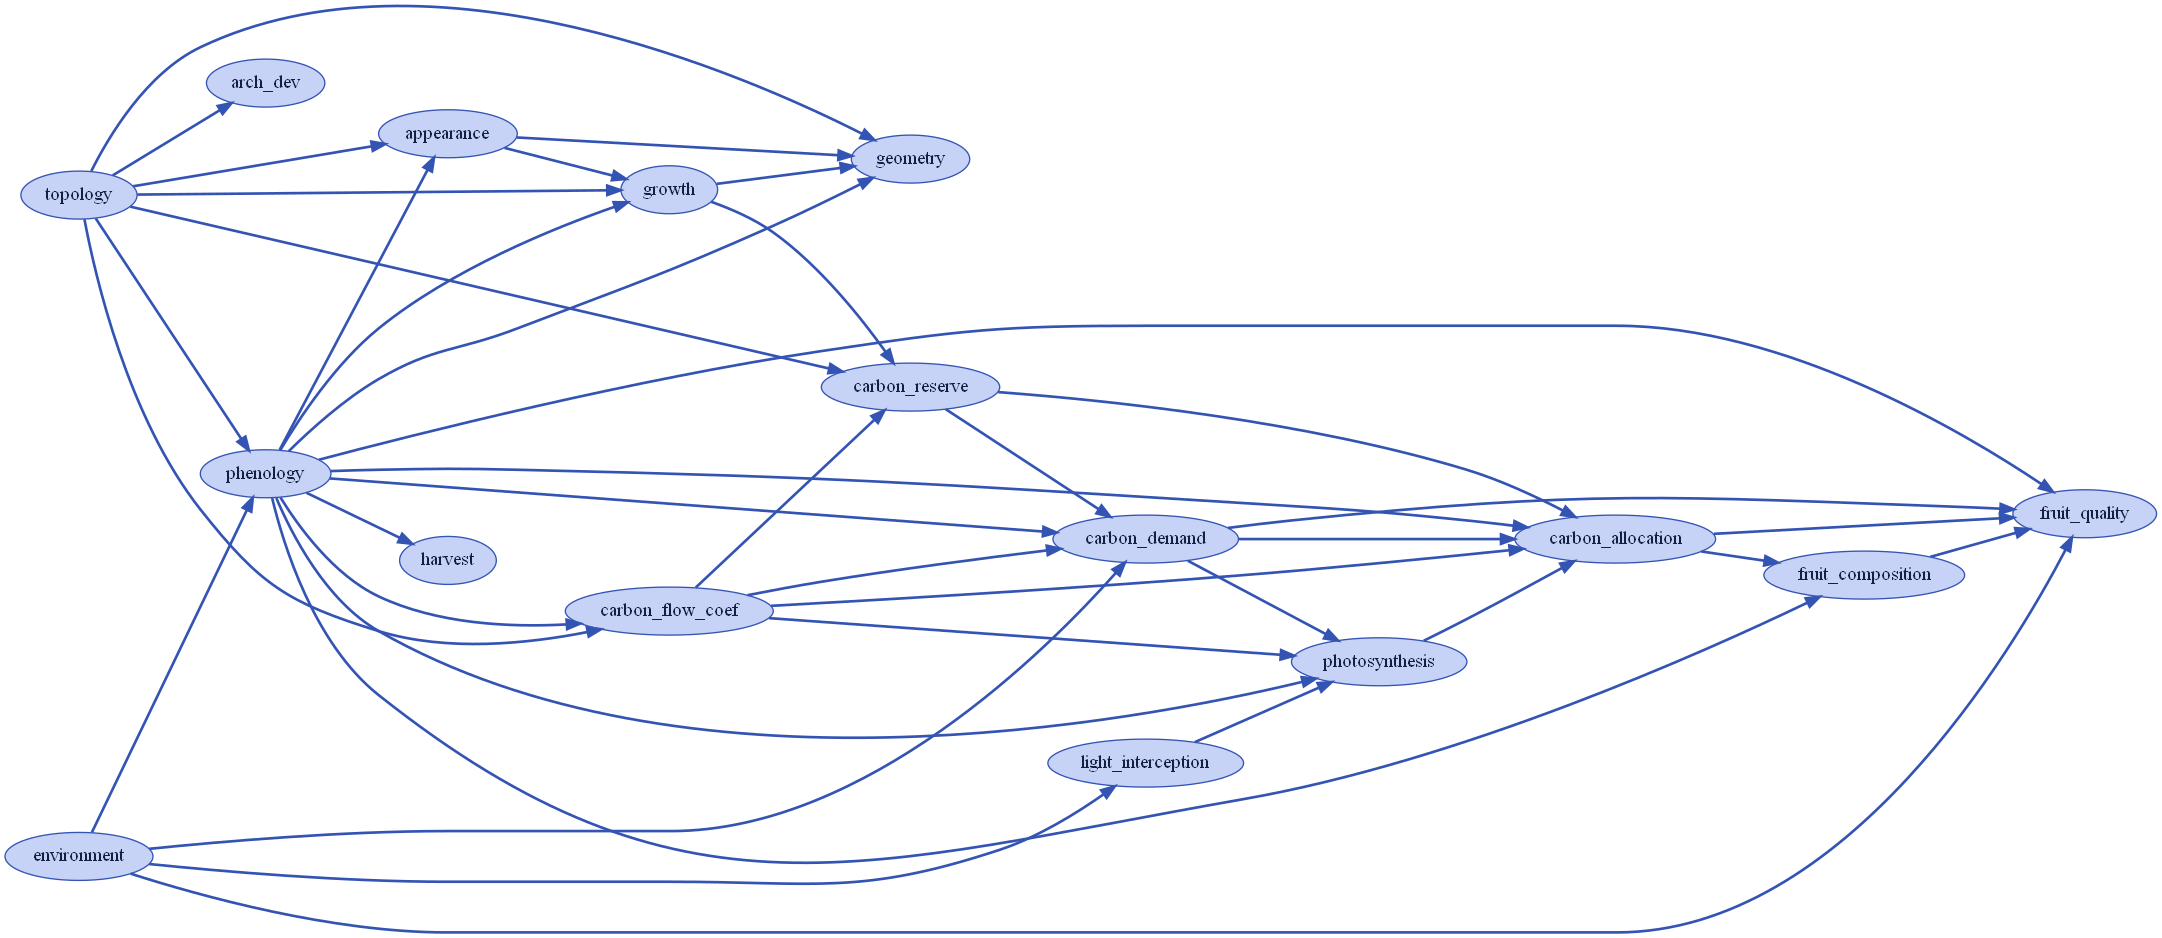

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import harvest
fruit_model.visualize()

## 1. Import field data :

In [3]:
tree_id = ['01','05','06','08','09','11','23','24','25','27']
tree = [pd.read_csv('../share/trees/branch_F14_01.csv'),
        pd.read_csv('../share/trees/branch_F14_05.csv'),
        pd.read_csv('../share/trees/branch_F14_06.csv'),
        pd.read_csv('../share/trees/branch_F14_08.csv'),
        pd.read_csv('../share/trees/branch_F14_09.csv'),
        pd.read_csv('../share/trees/branch_F14_11.csv'),
        pd.read_csv('../share/trees/branch_F14_23.csv'),
        pd.read_csv('../share/trees/branch_F14_24.csv'),
        pd.read_csv('../share/trees/branch_F14_25.csv'),
        pd.read_csv('../share/trees/branch_F14_27.csv')]
harvest_date = ['2003-01-28',
                '2003-01-25',
                '2003-02-01',
                '2003-02-10',
                '2003-01-28',
                '2003-01-27',
                '2003-01-25',
                '2003-02-03',
                '2003-01-18',
                '2002-12-28']
observed_FM_fruit = [203,287,122,379,148,193,305,469,400,363]

## 2. Exploration of simulation results for 1 branch :

In [ ]:
i = tree_id.index('25')
test_tree = tree[i]
test_harvest_date = harvest_date[i]

In [ ]:
graph = vmlab.load_graph(test_tree)
vmlab.check_graph(graph)
layout = graph.layout_reingold_tilford()
layout.rotate(-180)
ig.plot(graph, bbox=(0,0,500,400), layout=layout)

In [ ]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=test_tree,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='../share/setup/fruit_model_branch.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'carbon_flow_coef__max_distance_to_fruit': 10,
        'geometry__interpretation_freq': 5
    },
    output_vars={
        'topology': {
            'adjacency': 'day'
        },
        'environment': {
            'TM_day': 'day',
            'RH_day': 'day'
        },
        'carbon_allocation': {
            'DM_fruit': 'day',
            'DM_flesh': 'day',
            'carbon_supply': 'day'
        },
        'carbon_reserve':{
            'reserve_stem': 'day',
            'reserve_leaf': 'day'
        },
        'harvest': {
            'ripeness_index': 'day',
            'nb_fruit_harvested': None
        },
        'growth': {
            'nb_leaf': None,
        },
        'fruit_quality': {
            'FM_fruit': 'day',
            'W_flesh': 'day',
            'sucrose': 'day'
        }
    }
)

In [ ]:
ds_out = vmlab.run(setup, fruit_model, geometry=True)

In [ ]:
g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency[-1].data.astype(np.int64)])
layout = g.layout_reingold_tilford(root=0.)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(600, 400), **{
    'vertex_size': 1,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_label': [
        f'GU{idx}\nF:{int(ds_out.harvest__nb_fruit_harvested.data[idx])}\nL:{int(ds_out.growth__nb_leaf.data[idx])}' for idx in g.vs.indices
    ]
})

In [ ]:
ds = ds_out.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).sel({'day': slice(test_harvest_date)})
print('Predicted FM_fruit :', round(ds.fruit_quality__FM_fruit.max().to_pandas().tolist()))
print('Observed FM_fruit :', observed_FM_fruit[i])

In [ ]:
ig, axs = plt.subplots(1,2,figsize=(12,3))
ds.fruit_quality__FM_fruit.plot(ax=axs[0])
ds.carbon_allocation__DM_fruit.plot(ax=axs[1])
plt.show()

In [ ]:
ig, axs = plt.subplots(1,2,figsize=(12,3))
(ds.harvest__ripeness_index).plot(ax=axs[0], ylim=[0,1])
plt.ylabel('ripening_index_dd')
(ds.fruit_quality__sucrose/0.04).plot(ax=axs[1], ylim=[0,1])
plt.ylabel('ripening_index_sucrose')
plt.show()

In [ ]:
ig, axs = plt.subplots(3,1,figsize=(7,10))
ds_out.carbon_allocation__carbon_supply.plot(ax=axs[0])
ds_out.carbon_reserve__reserve_stem.plot(ax=axs[1])
ds_out.carbon_reserve__reserve_leaf.plot(ax=axs[2])
plt.show()

In [ ]:
ds_out.carbon_allocation__carbon_supply.plot(col='GU', col_wrap=8)
plt.show()

In [ ]:
ds_out.carbon_reserve__reserve_stem.plot(col='GU', col_wrap=8)
plt.show()

In [ ]:
ds_out.carbon_reserve__reserve_leaf.plot(col='GU', col_wrap=8)
plt.show()

In [ ]:
fig,ax = plt.subplots()
line1, = ax.plot(ds_out.environment__TM_day.sel({'day': slice('2002-09-01', '2003-04-01')}), label="TM [°C]", color="blue")
ax.set_ylabel("TM [°C]",fontsize=14)
plt.ylim([15,35])
ax2=ax.twinx()
line2, = ax2.plot(ds_out.environment__RH_day.sel({'day': slice('2002-09-01', '2003-04-01')}), label="RH [%]", color="orange")
ax2.set_ylabel("RH [%]",fontsize=14)
plt.ylim([0,100])
plt.legend(handles=[line1, line2], loc='lower right')
plt.show()

## 3. Simulation for the 10 branches :

In [4]:
d_max = 10

In [5]:
simulated_FM_fruit = []

for i in range(10) :
    setup = vmlab.create_setup(
        model=fruit_model,
        tree=tree[i],
        start_date='2002-06-01',
        end_date='2003-06-01',
        setup_toml='../share/setup/fruit_model_branch.toml',
        current_cycle=3,
        input_vars={
            'growth__leaf_senescence_enabled': False,
            'carbon_flow_coef__max_distance_to_fruit': d_max,
            'geometry__interpretation_freq': 15
        },
        output_vars={
            'carbon_allocation': {
                'DM_fruit': 'day'
            },
            'fruit_quality': {
                'FM_fruit': 'day'
            }
        }
    )
    
    ds_out = vmlab.run(setup, fruit_model, geometry=False)
    ds = ds_out.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).sel({'day': slice(harvest_date[i])})
    simulated_FM_fruit.append(ds.fruit_quality__FM_fruit.max().to_pandas().tolist())

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

d:\gitrepos\vmango-lab\vmlab\processes\carbon_allocation.py:279: UserWarning: Vegetative part of the system dies ...
  warnings.warn('Vegetative part of the system dies ...')


             0% | initialize 

d:\gitrepos\vmango-lab\vmlab\processes\carbon_allocation.py:279: UserWarning: Vegetative part of the system dies ...
  warnings.warn('Vegetative part of the system dies ...')


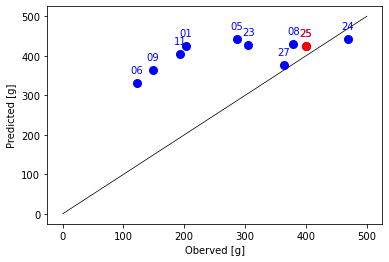

In [6]:
i = tree_id.index('25')
plt.plot([0, 500],[0, 500],'k-',lw=0.75)
plt.plot(observed_FM_fruit, simulated_FM_fruit, 'bo', markersize=8)
for x,y,label in zip(observed_FM_fruit, simulated_FM_fruit, tree_id):
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', color="b")
plt.plot(observed_FM_fruit[i], simulated_FM_fruit[i], 'ro', markersize=8)
plt.annotate(tree_id[i], (observed_FM_fruit[i], simulated_FM_fruit[i]), textcoords="offset points", xytext=(0,10), ha='center', color="r")
plt.xlabel('Oberved [g]')
plt.ylabel('Predicted [g]')
plt.show()

In [7]:
data = [ tree_id, observed_FM_fruit, [round(elem) for elem in simulated_FM_fruit] ]
pd.DataFrame(data, columns=data.pop(0), index=['observed','simulated'])

,01,05,06,08,09,11,23,24,25,27
observed,203,287,122,379,148,193,305,469,400,363
simulated,424,442,332,430,363,404,427,442,424,378


In [63]:
sort_index = np.argsort(observed_FM_fruit)
simulated_FM_fruit = [round(elem) for elem in simulated_FM_fruit]
data = [np.array(tree_id)[sort_index],
        np.array(observed_FM_fruit)[sort_index],
        np.array(simulated_FM_fruit)[sort_index]]
pd.DataFrame(data, columns=data.pop(0), index=['observed','simulated'])

,06,09,11,01,05,23,27,08,25,24
observed,122,148,193,203,287,305,363,379,400,469
simulated,332,363,404,424,442,427,378,430,424,442
